In [94]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split


import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [108]:
history =  {}

In [145]:
input_size = (256,256)
data_dir = "./MIT_split"

key_execution = "scale_"+str(input_size) 
history[key_execution] = {"losses": None, "acc": None }

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 8


In [146]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}


In [147]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1881
     Root location: ./MIT_split/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(256, 256))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 807
     Root location: ./MIT_split/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(256, 256))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [254]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "test": []}
    losses = {"train": [], "test": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())
            losses[phase].append(epoch_loss)


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

In [301]:
class Efficient_net(nn.Module):
    def __init__(self, freeze= True):
        super(Efficient_net, self).__init__()
        
        self._freeze = freeze
        
        self._eff = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
        
        self.features = self._eff.features
        
        self.avgpool = self._eff.avgpool
        
        self.classifier = self._eff.classifier
        
        self.gradients = None
        
        self.set_parameter_requires_grad(freeze)
        
        
    def set_parameter_requires_grad(self, feature_extracting):
        if feature_extracting:
            for param in self._eff.parameters():
                param.requires_grad = False

    def forward(self, x):
        
        x = self._eff.features(x)
        if not self._freeze:
            print("gola")
            h = x.register_hook(self.activations_hook)
        
        x = self._eff.avgpool(x)
        
        x = self._eff.classifier(x)
        
        
        return x
    
    def set_linear(self, output_size):
        self.classifier[-1] = nn.Linear(1280, output_size)
        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def get_activations_gradient(self):
        return self.gradients
        
        

In [273]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
    set_parameter_requires_grad(model, True)
    model.classifier[-1] = nn.Linear(1280,num_classes)
    #model.fc = nn.Linear(1000,num_classes)# YOUR CODE HERE!
    
    input_size = 224
        
    return model, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


# Number of classes in the dataset
num_classes = 8

# Initialize the model
#model, input_size = initialize_model(num_classes)
model = Efficient_net()
model.set_linear(num_classes)


In [274]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(len(params_to_update))
# Observe that all parameters are being optimized

2


In [275]:
params_to_update

[Parameter containing:
 tensor([[ 1.9262e-02,  1.5998e-02,  1.0271e-02,  ...,  2.7283e-02,
          -1.4287e-02,  6.9648e-03],
         [ 9.4554e-03, -5.2899e-03,  2.3362e-02,  ...,  1.2329e-02,
          -2.0069e-02,  4.5791e-03],
         [-4.0672e-03,  2.5710e-02,  2.0962e-02,  ...,  9.8056e-03,
          -2.1771e-03, -5.7887e-03],
         ...,
         [ 1.4072e-02, -1.6104e-02, -1.0625e-02,  ..., -5.3254e-03,
           9.2120e-03,  4.0540e-05],
         [-1.5584e-02,  1.5882e-02, -2.2670e-02,  ...,  2.0913e-02,
          -1.4672e-02,  7.0567e-03],
         [-2.9943e-04, -1.0710e-02,  1.9999e-02,  ...,  2.5369e-02,
          -2.3599e-02, -2.6575e-03]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0215,  0.0051, -0.0078, -0.0116, -0.0160, -0.0108, -0.0057,  0.0244],
        requires_grad=True)]

In [259]:
# Send the model to GPU
model =model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
model, hist, losses = train_model(model._eff, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 1.1047 Acc: 0.6736
test Loss: 0.6521 Acc: 0.8476

Epoch 1/14
----------
train Loss: 0.6061 Acc: 0.8267
test Loss: 0.4769 Acc: 0.8550

Epoch 2/14
----------


KeyboardInterrupt: 

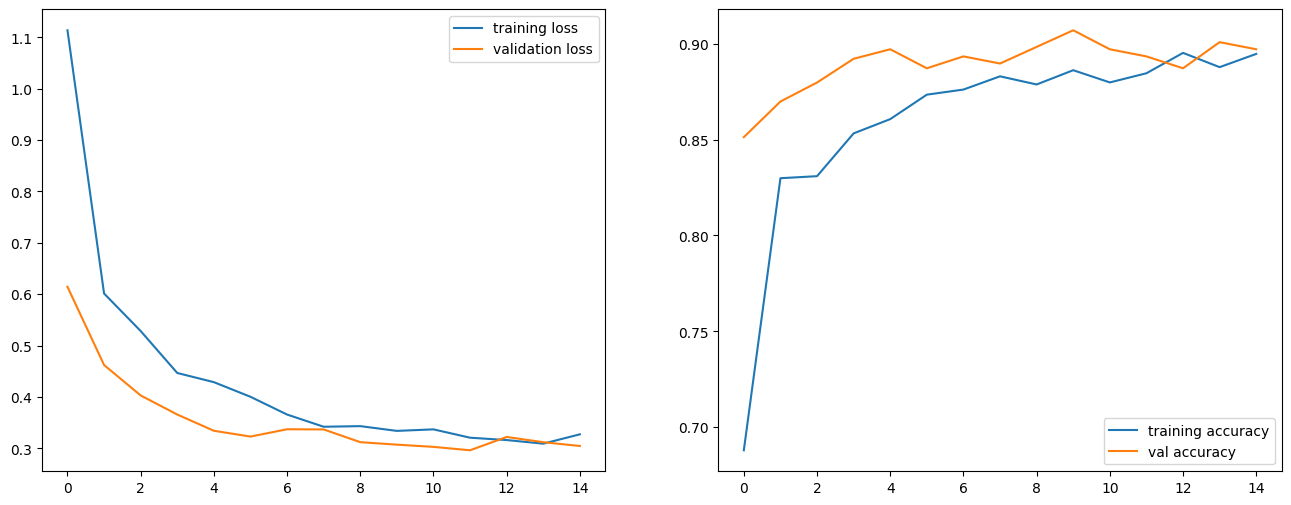

In [153]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["test"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["test"],label="val accuracy")
ax2.legend()

plt.show()  

In [154]:
history[key_execution]["losses"] = losses
history[key_execution]["acc"] = hist


In [157]:
import pandas as pd
import seaborn as sns

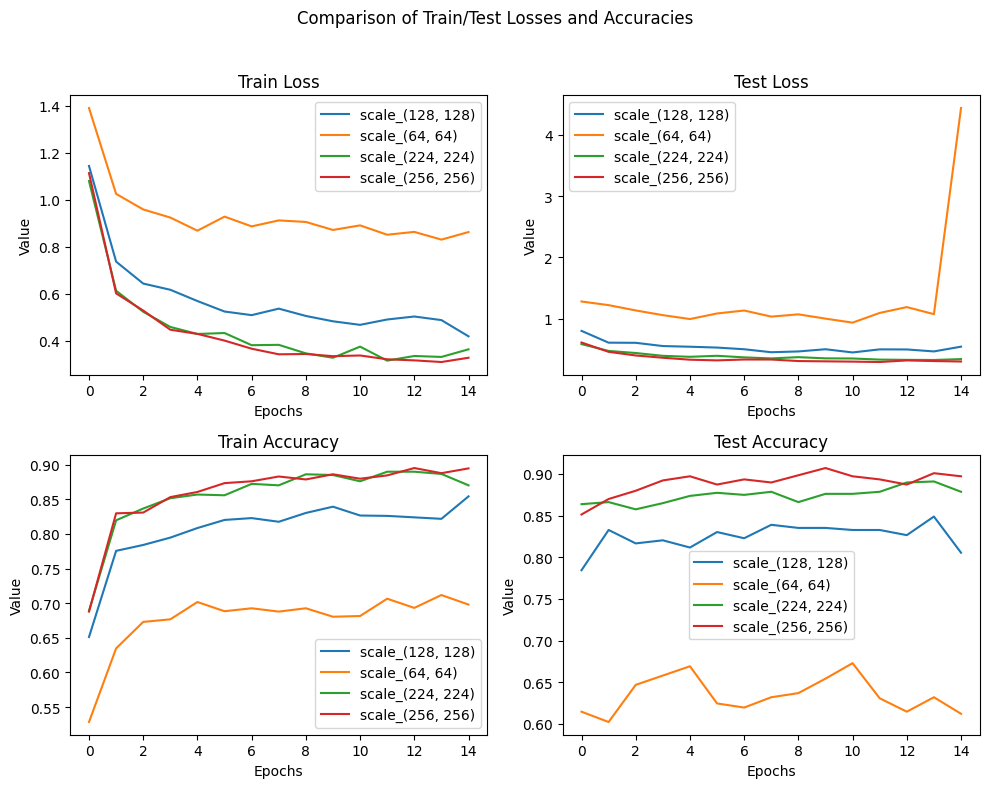

In [162]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Comparison of Train/Test Losses and Accuracies')

# Iterate over each key in the dictionary
for i, (key, values) in enumerate(history.items()):
    # Train Loss plot
    axs[0, 0].plot(values['losses']['train'], label=key)
    axs[0, 0].set_title('Train Loss')

    # Test Loss plot
    axs[0, 1].plot(values['losses']['test'], label=key)
    axs[0, 1].set_title('Test Loss')

    # Train Accuracy plot
    axs[1, 0].plot(values['acc']['train'], label=key)
    axs[1, 0].set_title('Train Accuracy')

    # Test Accuracy plot
    axs[1, 1].plot(values['acc']['test'], label=key)
    axs[1, 1].set_title('Test Accuracy')

# Add legends and labels
for ax in axs.flat:
    ax.legend()
    ax.set(xlabel='Epochs', ylabel='Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

## Applying GradCam

In [308]:
# initialize the VGG model
vgg = Efficient_net(freeze=False)
vgg.set_linear(8)
eff = vgg._eff

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloaders_dict["test"]))
print(img.shape)

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)

torch.Size([8, 3, 256, 256])
gola


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10240x1 and 1280x8)

In [303]:
pred

tensor([7, 4, 4, 3, 0, 7, 2, 7])

In [304]:
print(pred[:, 1])

IndexError: too many indices for tensor of dimension 1

In [305]:
print(eff(img)[:,pred[0]])

tensor([ 0.5361, -0.0361,  0.1405, -0.1343,  0.1265,  0.2793, -0.1622,  0.5941],
       grad_fn=<SelectBackward0>)


In [306]:
# get the gradient of the output with respect to the parameters of the model
eff(img)[0, pred[0]].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
print(gradients)
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

None


TypeError: mean() received an invalid combination of arguments - got (NoneType, dim=list), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)
